In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
def cross_validate_learning_rate(estimator, x_train, y_train, cv = 5, scoring = 'roc_auc', return_train_score = True):
    results = cross_validate(estimator,
                            x_train,
                            y_train,
                            cv = cv,
                            scoring=scoring,
                            return_train_score = return_train_score ) 
    train_scores = results['train_score']
    test_scores = results['test_score']
    print("train_scores: {}".format(np.mean(train_scores)))
    print("test_scores: {}".format(np.mean(test_scores)))

    lc = learning_curve(estimator, 
                        x_train, 
                        y_train, 
                        cv=cv, 
                        scoring=scoring)
    samples, train, test = lc[0],lc[1],lc[2]
    plt.plot(samples, np.mean(train, axis=1))
    plt.plot(samples, np.mean(test, axis=1))

In [3]:
from sklearn.model_selection import GridSearchCV
def grid_search_param(X, y,nfolds, param_grid, model_sklearn, scoring = 'roc_auc'):
    grid_search = GridSearchCV(model_sklearn, param_grid, cv=nfolds, return_train_score=True, scoring=scoring)
    grid_search.fit(X, y)
    return grid_search

In [4]:
path = '../data'
y_train = pd.read_csv(f'{path}/y_train.csv', index_col = 'key_value')

In [5]:
list_train_probs = []
list_train_probs.append(pd.read_pickle('train_probs_lightgbm.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_lightgbm_cf.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_rnn.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_randomforrest.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_xgb.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_gbc.pkl'))
train = pd.concat(list_train_probs, axis=1)
train.columns = ['probs_lightgbm','probs_lightgbm_cf','probs_rnn','probs_randomforrest','probs_xgb', 'probs_gbc']
train

,probs_lightgbm,probs_lightgbm_cf,probs_rnn,probs_randomforrest,probs_xgb,probs_gbc
key_value,,,,,,
0,0.075889,0.052167,0.077679,0.054667,0.085660,0.054725
1,0.180585,0.157569,0.123964,0.181333,0.285724,0.111328
2,0.028284,0.029362,0.034087,0.114667,0.022070,0.053502
3,0.006474,0.006416,0.015480,0.005333,0.012798,0.029900
4,0.914879,0.934945,0.866782,0.765333,0.949458,0.922300
...,...,...,...,...,...,...
358482,0.052474,0.030986,0.089263,0.100000,0.038495,0.061685
358483,0.058666,0.067142,0.134463,0.085333,0.062367,0.089544
358484,0.340211,0.328420,0.302729,0.246667,0.264007,0.331772


In [6]:
list_test_probs = []
list_test_probs.append(pd.read_pickle('test_probs_lightgbm.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_lightgbm_cf.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_rnn.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_randomforrest.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_xgb.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_gbc.pkl'))
test = pd.concat(list_test_probs, axis=1)
test.columns = ['probs_lightgbm','probs_lightgbm_cf','probs_rnn','probs_randomforrest','probs_xgb', 'probs_gbc']

In [7]:
keep_columns = ['probs_lightgbm','probs_lightgbm_cf','probs_gbc']
train = train[keep_columns]
test = test[keep_columns]

In [8]:
train.corr()

,probs_lightgbm,probs_lightgbm_cf,probs_gbc
probs_lightgbm,1.000000,0.979399,0.950601
probs_lightgbm_cf,0.979399,1.000000,0.946376
probs_gbc,0.950601,0.946376,1.000000


In [9]:
test.corr()

,probs_lightgbm,probs_lightgbm_cf,probs_gbc
probs_lightgbm,1.000000,0.989030,0.973431
probs_lightgbm_cf,0.989030,1.000000,0.970499
probs_gbc,0.973431,0.970499,1.000000


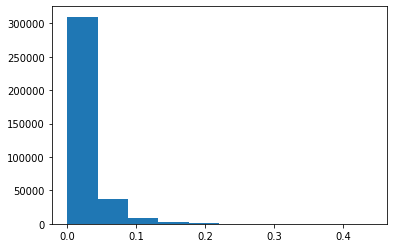

In [10]:
plt.hist(np.std(train.values, axis=1));

### Entrenando el modelo final

In [11]:
from sklearn.linear_model import LogisticRegression
### definir los parametros a tunear
Cs = [0.1, 0.3, 0.8, 0.9, 1.0]
# https://neurtu.readthedocs.io/examples/logistic_regression_scaling.html
solvers = ['lbfgs','saga','newton-cg'] # newton-cg, sag, lbfgs, liblinear, saga
param_grid = {'C': Cs,'solver':solvers}
### encontrando los hiper_parámetros
fitting=grid_search_param(train, y_train.target, 5,param_grid, LogisticRegression(penalty="l2", tol=0.0001, random_state=42), scoring='roc_auc')
### instanciar el estimador
estimator = fitting.best_estimator_
print(estimator)
### aplicar cross_validate y learning_rate 
# cross_validate_learning_rate(estimator, train, y_train, scoring='roc_auc')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)


train_scores: 0.8480576708784507
test_scores: 0.8480511858439422


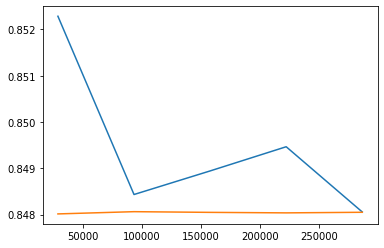

In [12]:
### aplicar cross_validate y learning_rate 
cross_validate_learning_rate(estimator, train, y_train.target, scoring='roc_auc')

In [13]:
estimator.fit(train, y_train.target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
test_stacking = pd.Series(estimator.predict_proba(test)[:,-1], index=test.index, name = 'target')
test_stacking

key_value
0         0.046411
1         0.082767
2         0.054280
3         0.569868
4         0.136302
            ...   
396661    0.070589
396662    0.175882
396663    0.200699
396664    0.058848
396665    0.069094
Name: target, Length: 396666, dtype: float64

In [15]:
test_stacking.to_csv("../results/stacking_3models_LGBM2_GBC_0.84805.csv")  ### score de ***** en la tabla publica

In [ ]:
# test_stacking.to_csv("../results/stacking_3models_LGBM2_R_0.84729.csv")  ### score de 0.84927 en la tabla publica
# test_stacking.to_csv("../results/stacking_6models_0.84767.csv")  ### score de 0.84910 en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_LGBM2_RNN_0.84830.csv")  ### score de 0.84974 en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_LGBM2_RF_0.84694.csv")  ### score de 0.84874  en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_LGBM2_XGB_0.84807.csv")  ### score de 0.84977  en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_LGBM2_0.84811.csv")  ### score de 0.84970  en la tabla publica
# test_stacking.to_csv("../results/stacking_2models_LGBM2_0.84801.csv")  ### score de 0.84992 en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_CB_LGBM2_0.84834.csv")  ### score de 0.84991 en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_CB_LGBM2_0.84833.csv") ### score de 0.84992 en la tabla publica
# test_stacking.to_csv("../results/stacking_2models_CB_LGBM_0.84721.csv") ### score de 0.84882 en la tabla publica

In [ ]:
### Por lo que se puede concluir que los dos modelos de lightGBM (el normal, y el que toma en cuenta las categoricas).
### Tienen mejor performance